In [108]:
import loompy
import numpy as np
import pandas as pd
import scvelo as sv
import anndata
import scanpy as sc
import time
import skdim
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from algorithms.stabilized_ICA import StabilizedICA
from elpigraph_ps_tools import *
from scipy import optimize
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks
from sklearn.decomposition import PCA
from collections import Counter
from scipy import stats

def load_signature_file(file):
    sigs = {}
    with open(file,'r',encoding="utf8",errors='ignore') as fin:
        line = fin.readline().strip('\n').strip(' ')
        while line:
            parts = line.split('\t')
            lst = parts[2:]
            lst = [s.split('[')[0] for s in lst if not s=='']
            sigs[parts[0]] = lst
            line = fin.readline().strip('\n').strip(' ')
    return sigs

def calc_scores(anndata,signature_dict):
    matrix = anndata.to_df().to_numpy()
    scores_dic = {}
    for key in signature_dict:
        names = np.array(signature_dict[key])
        inds = np.where(np.isin(anndata.var_names,names))[0]
        matrix_sel = matrix[:,inds]
        scores = np.mean(matrix_sel,axis=1)
        scores_dic[key] = scores
    return scores_dic

def calc_histone_score(adata2k):
    histone_names1 = np.argwhere(adata2k.var_names.str.startswith('H1'))
    histone_names2 = np.argwhere(adata2k.var_names.str.startswith('H2'))
    histone_names3 = np.argwhere(adata2k.var_names.str.startswith('H3'))
    histone_names4 = np.argwhere(adata2k.var_names.str.startswith('H4'))
    histone_names5 = np.argwhere(adata2k.var_names.str.startswith('HIST'))
    histone_names = np.union1d(np.union1d(histone_names1,histone_names2),np.union1d(histone_names3,histone_names4))
    histone_names = np.union1d(histone_names,histone_names5)
    histone_names = adata2k.var_names[histone_names]
    print('Found histone genes:',*histone_names)
    inds_histones = np.where(np.isin(adata2k.var_names,histone_names))[0]
    matrix = adata2k.to_df().to_numpy()
    matrix_sel = matrix[:,inds_histones]
    scores = np.mean(matrix_sel,axis=1)
    return scores

def subtract_cell_cycle_trajectory(X,partition,points):
    r2scores = []
    X1 = X[points,:]
    X_ro = np.zeros((X.shape[0],X.shape[1]))
    partition_points = partition[points]
    inds = {}
    for k in range(len(partition_points)):
        j = partition_points[k][0]
        if not j in inds:
            inds[j] = [k]
        else:
            inds[j].append(k)
    XT = X1.T
    for j in range(X1.shape[0]):
        k = partition_points[j][0]
        ind = np.array(inds[k])
        X_ro[j,:] = (XT[:,j] - np.mean(XT[:,ind],axis=1)).T
    residue_matrix = X1 - X_ro
    residues_var = np.var(residue_matrix,axis=0)
    vrs = np.var(X1,axis=0)
    r2scores = residues_var/vrs
    return X_ro, residue_matrix, r2scores

def compute_trajectory(X,total_counts,number_of_nodes=30,mu=0.1):
    egr = elpigraph.computeElasticPrincipalCircle(X,number_of_nodes,Mu=mu)    
    partition, dists = elpigraph.src.core.PartitionData(X = X, NodePositions = egr[0]['NodePositions'], 
                                                        MaxBlockSize = 100000000, TrimmingRadius = np.inf,
                                                        SquaredX = np.sum(X**2,axis=1,keepdims=1))
    ProjStruct = elpigraph.src.reporting.project_point_onto_graph(X = X,
                                         NodePositions = egr[0]['NodePositions'],
                                         Edges = egr[0]['Edges'][0],
                                         Partition = partition)
    pca = PCA()
    mean_vector = np.mean(X,axis=0)
    u = pca.fit_transform(X)
    v = pca.components_.T
    s = pca.explained_variance_
    nodep = egr[0]['NodePositions']
    edges = egr[0]['Edges'][0]
    nodep_pca = np.matmul(nodep-mean_vector,v)
    node_read_counts = np.zeros(nodep.shape[0])
    edge_abs_diff_counts = np.zeros(len(edges))
    for i in range(len(nodep)):
        node_read_counts[i] = np.mean(total_counts[np.where(partition==i)[0]])
    for i,e in enumerate(edges):
        edge_abs_diff_counts[i] = np.abs(node_read_counts[e[0]]-node_read_counts[e[1]])
    edge_to_remove = np.argmax(edge_abs_diff_counts)
    print('Selected edge to remove',edge_to_remove)
    X_elpigraph_training = X
    gr = egr[0].copy()
    edges = gr['Edges'][0]
    starting_node = edges[edge_to_remove,1]
    edges = np.delete(gr['Edges'][0],edge_to_remove,axis=0)
    w1 = np.delete(gr['Edges'][1],edge_to_remove,axis=0)
    w2 = np.delete(gr['Edges'][2],edge_to_remove,axis=0)
    gr['Edges'] = (edges,w1,w2)
    traj = extract_trajectories(gr,starting_node,verbose=False)
    print('Trajectory:',traj)
    traj = traj[0]
    #traj.reverse()
    ProjStruct = project_on_tree(X_elpigraph_training,gr)
    PseudoTimeTraj = quantify_pseudotime([traj],ProjStruct,producePlot=False)
    points = PseudoTimeTraj[0]['Points'] 
    pst = PseudoTimeTraj[0]['Pseudotime']
    return egr, pst, points, partition, traj

def calc_curvature(nodep,smoothing_factor=10):
    splines = []
    derivs = []
    for i in range(nodep.shape[1]):
        spline = UnivariateSpline(np.linspace(0,nodep.shape[0]-1,nodep.shape[0]), nodep[:,i],s=0,k=3)
        splines.append(spline)
        derivs.append(spline.derivative(n=2))
    n_points = nodep.shape[0]
    curv = np.zeros(nodep.shape[0])
    x = np.linspace(0,nodep.shape[0]-1,n_points)
    temp = np.zeros((n_points,nodep.shape[1]))
    print(temp.shape)
    for i in range(len(derivs)):
        temp[:,i] = derivs[i](x)
    curv = np.sqrt(np.sum(temp**2,axis=1))
    curv_spl = UnivariateSpline(x,curv,s=np.var(curv)*smoothing_factor,k=3)
    return x, curv_spl(x)

def calc_curvature_cyclic(nodep,smoothing_factor=5):
    nodep3 = np.concatenate((nodep,nodep,nodep),axis=0)
    x,curv = calc_curvature(nodep3,smoothing_factor=smoothing_factor)
    return x[nodep.shape[0]:2*nodep.shape[0]]-nodep.shape[0], curv[nodep.shape[0]:2*nodep.shape[0]]

def classify_genes_by_ic(Metagenes_cc):
    class_gene_cc = []
    for g in adata_cc.var_names:
        col = Metagenes_cc[g].to_numpy()
        i = np.argmax(col)
        if (g.startswith('HIST'))|(g.startswith('H1'))|(g.startswith('H2'))|(g.startswith('H3'))|(g.startswith('H4')):
            class_gene_cc.append('Histones')
        else:
            if i==0:
                class_gene_cc.append('G2M genes')
            if i==1:
                class_gene_cc.append('G1S genes')
            if i==2:
                class_gene_cc.append('G2M_INH genes')
            if i==3:
                class_gene_cc.append('HIST-IC genes')
    return class_gene_cc

In [46]:
# Here we load already pre-processed data and the corresponding S matrix (can be done directly from scycle)
file = '../EwingSarcoma_Miller2020/CHLA9_proc.h5ad'
adata = sc.read_h5ad(file)

array([[ 1.96516538,  0.25359048,  0.27085673, ...,  0.63107115,
        -0.34650052, -0.12096741],
       [-0.78056009, -0.13203008, -0.42079873, ..., -0.09761573,
        -0.44101577, -0.27214388],
       [-0.41900831, -0.70352004, -0.93548984, ..., -0.03386695,
         0.20774555, -0.51058276],
       ...,
       [ 0.22342328,  0.35571153,  0.3017031 , ..., -0.21139042,
         0.9422203 ,  0.9427689 ],
       [ 1.14224037,  0.15955358,  0.12016602, ..., -0.37012117,
        -1.17336745, -0.95268196],
       [-0.48105645, -0.20196544,  0.17410028, ...,  0.03351495,
        -1.15079824,  0.00761206]])

In [51]:
Metagenes = pd.DataFrame(adata.uns['S_matrix'], columns = adata.var_names , index = ['IC'+ str(i+1) for i in range(adata.uns['S_matrix'].shape[0])])
display(Metagenes.head())

,MALAT1,MT-CO2,MT-CO1,HIST1H4C,MT-CO3,MT-ATP6,NEAT1,HSP90AA1,CENPF,MT-CYB,...,EN1,AL356488.3,RELT,CBWD3,TXNL4B,TMEM119,PRR36,AC092747.4,AL355001.2,PCGF5
IC1,1.965165,0.253590,0.270857,0.093734,0.060246,-0.692015,8.916860,0.019415,0.656725,0.188799,...,0.749339,0.105706,0.328745,0.929625,0.419941,0.099891,0.381955,0.631071,-0.346501,-0.120967
IC2,-0.780560,-0.132030,-0.420799,1.881720,-0.421324,-0.793863,-0.195548,-0.748580,-2.175001,-0.365254,...,-0.221695,-0.085475,0.918145,0.046514,-0.318743,-0.200540,0.537043,-0.097616,-0.441016,-0.272144
IC3,-0.419008,-0.703520,-0.935490,-1.417441,-0.839171,-0.806889,3.214755,1.160813,-1.698079,-0.617155,...,0.110337,-0.355284,-0.319848,-0.360937,-0.447847,-0.920999,0.346266,-0.033867,0.207746,-0.510583
IC4,0.193920,0.179849,0.182658,26.164640,0.181977,0.181652,-0.704498,-1.347359,2.267890,-0.088364,...,-0.280144,-0.650972,-0.330024,-0.133253,0.671058,-0.288112,0.187267,-0.285829,0.330680,-0.197374
IC5,-0.752897,-0.284165,1.930620,0.969671,1.042721,0.608425,-4.109532,-2.111955,-0.402066,2.382082,...,0.067317,-0.161126,0.768966,0.303578,-0.212899,0.479298,0.954749,-0.197202,-0.290514,-0.388052


In [56]:
# We compute the scores of the components

threshold = 3
dfs = Metagenes.transpose()
gmtfile = file[:-5]+'.gmt'
with open(gmtfile,'w') as fout:
    for s in dfs.columns:
        fout.write(s+'\tna\t')
        for i in range(dfs[s].shape[0]):
            val = float(dfs[s].iloc[i])
            gn = dfs.index[i]
            if val>threshold:
                fout.write(gn+'\t')
        fout.write('\n')
        
signature_dict = load_signature_file(gmtfile)
sc.pp.highly_variable_genes(adata,n_top_genes=2001,n_bins=20)
ind_genes2k = np.where(adata.var['highly_variable'])[0]
adata2k = adata[:,ind_genes2k]

scores_dic = calc_scores(adata2k,signature_dict)
scores_dic['HISTONES'] = calc_histone_score(adata2k)
for s in scores_dic:
    adata.obs[s] = scores_dic[s]

Found histone genes: HIST1H4C H3F3B HIST1H1B HIST1H1D H1FX HIST1H1C H1F0 HIST1H1E H2AFX HIST2H2AC HIST1H2BH HIST1H2AG HIST1H2AC HIST1H2BC HIST1H4E HIST1H2AL HIST1H3B HIST1H2AH HIST2H2BF HIST3H2A HIST1H3G HIST1H2BD HIST1H2AE HIST1H2BN


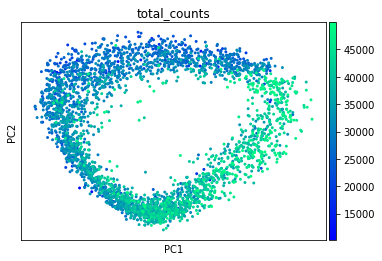

In [57]:
sc.tl.pca(adata,n_comps=50)
X_pca = adata.obsm['X_pca']
sc.pl.pca(adata,cmap='winter',color='total_counts')

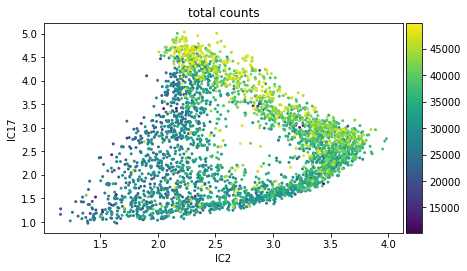

In [84]:
idx_g1s = adata.uns['scycle']['enrich_components']['G1']['S']
idx_g2m = adata.uns['scycle']['enrich_components']['G2']['M+']
idx_g2m_inh = adata.uns['scycle']['enrich_components']['G2']['M-']
idx_histone = adata.uns['scycle']['enrich_components']['Histone']
sc.pl.scatter(adata,x='IC'+str(idx_g1s+1),y='IC'+str(idx_g2m+1),color='total_counts')
#sc.pl.scatter(adata,x='IC'+str(idx_g2m+1),y='IC'+str(idx_g2m_inh+1),color='total_counts')
#sc.pl.scatter(adata,x='IC'+str(idx_g1s+1),y='IC'+str(idx_histone+1),color='total_counts')

The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  3460  points and  4  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||50	0.1174	50	50	50	0	0	0	0.0856	0.0813	0.9655	0.9672	0.026	0.0058	0.2885	14.4271	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
2.29  seconds elapsed


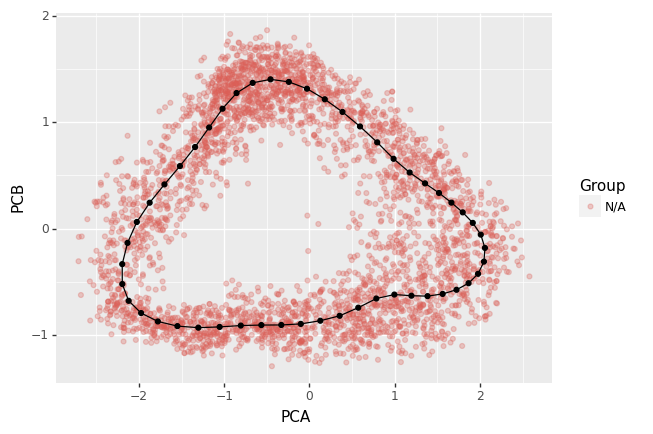

[<ggplot: (8767882657789)>]
Selected edge to remove 11
Trajectory: [[19, 43, 2, 35, 25, 28, 41, 48, 30, 3, 6, 24, 21, 32, 42, 47, 37, 18, 9, 1, 13, 15, 11, 39, 49, 44, 33, 23, 26, 34, 7, 29, 45, 0, 38, 20, 17, 4, 22, 27, 5, 40, 46, 36, 31, 10, 14, 8, 12, 16], [19]]


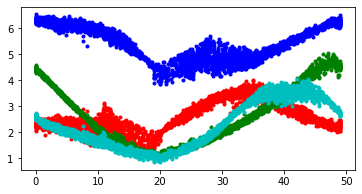

In [110]:
# Compute cell cycle trajectory

r2_threshold = 0.4
mu = 0.2
number_of_nodes = 50
total_counts = adata.obs['total_counts'].to_numpy()

cell_cycle_ics_data = pd.DataFrame(data={G1S_score:adata.obs['IC'+str(idx_g1s+1)],
                                         G2M_score:adata.obs['IC'+str(idx_g2m+1)],
                                         G2M_INH_score:adata.obs['IC'+str(idx_g2m_inh+1)],
                                         HISTONE_score:adata.obs['IC'+str(idx_histone+1)]}).to_numpy().astype(np.float64)

egr_ic, pst_ic, points_ic, partition_ic, traj_ic = compute_trajectory(cell_cycle_ics_data,
                                                       total_counts,
                                                       mu=mu,
                                                       number_of_nodes=number_of_nodes)

plt.figure(figsize=(6,3))
plt.plot(pst_ic,adata.obs['IC'+str(idx_g1s+1)][points_ic],'r.',label='G1S')
plt.plot(pst_ic,adata.obs['IC'+str(idx_g2m+1)][points_ic],'g.',label='G2M')
plt.plot(pst_ic,adata.obs['IC'+str(idx_g2m_inh+1)][points_ic],'b.',label='G2M INH')
plt.plot(pst_ic,adata.obs['IC'+str(idx_histone+1)][points_ic],'c.',label='HISTONE')
plt.show()

In [106]:
# Subtract the cell cycle trajectory from the data
partition = partition_ic
points = points_ic

X_ro, residue_matrix, r2scores = subtract_cell_cycle_trajectory(adata.X,partition,points)
ind = np.where(r2scores>r2_threshold)[0]
print('Cell cycle genes fround from the trajectory in 4IC space:',len(ind))
print('Top ones:',list(adata.var_names[np.where(r2scores>0.9)[0]]))

Cell cycle genes fround from the trajectory in 4IC space: 515
Top ones: ['HIST1H4C', 'TOP2A', 'HMGB2', 'UBE2S', 'KPNA2', 'ASPM', 'CCNB1', 'TPX2', 'CDC20', 'HIST1H1B', 'UBE2C', 'CKS2', 'CENPE', 'NUSAP1', 'ARL6IP1', 'RRM2', 'HIST1H1D', 'DLGAP5', 'HMMR', 'CDK1', 'KIF2C', 'AURKA', 'SGO2', 'GTSE1', 'NUF2', 'KIF14', 'NCAPG', 'AURKB', 'CCNA2', 'TACC3', 'PIF1', 'NDC80', 'CDCA8']


Trying to set attribute `.var` of view, copying.
... storing 'Class_gene_cc' as categorical


Counter({'G1S genes': 197, 'G2M genes': 159, 'G2M_INH genes': 104, 'HIST-IC genes': 46, 'Histones': 22})


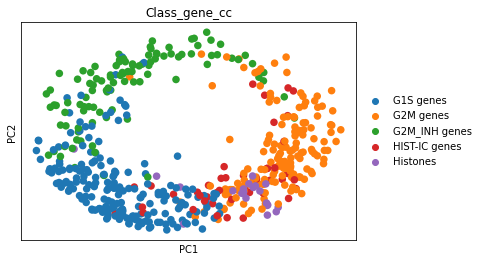

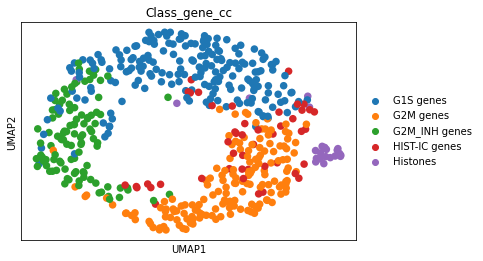

In [121]:
# Cluster cell cycle genes

Metagenes_cc = Metagenes.iloc[[idx_g1s,idx_g2m,idx_g2m_inh,idx_histone]]
adata_cc = adata[:,ind]
class_gene_cc = classify_genes_by_ic(Metagenes_cc)
adata_cc.var['Class_gene_cc'] = class_gene_cc
print(Counter(class_gene_cc))

adata_cc_T = adata_cc.copy().T
Xcc = adata_cc_T.X
Xcc = (stats.zscore(Xcc.T)).T
adata_cc_T.X = Xcc
sc.tl.pca(adata_cc_T,n_comps=10)
sc.pl.pca(adata_cc_T,color='Class_gene_cc')
sc.pp.neighbors(adata_cc_T, n_neighbors=20)
sc.tl.umap(adata_cc_T)
sc.pl.umap(adata_cc_T,color='Class_gene_cc')

(150, 10)


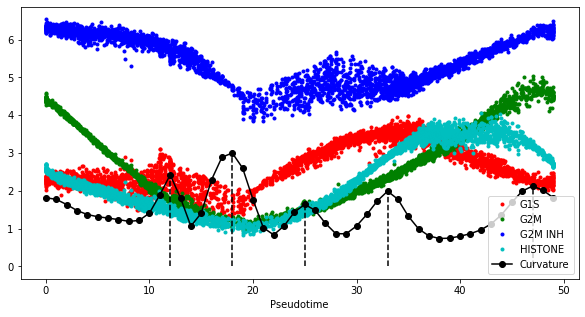

In [124]:
# Curvature analysis

max_dimension = 10
scale = 3

#egr = egr_ic
#traj = traj_ic
egr = egr_sc
traj = traj_sc


curv = np.zeros(len(traj))
nodep = egr[0]['NodePositions']
reduced_dimension = np.min([nodep.shape[1],max_dimension])
x, curv = calc_curvature_cyclic(nodep[traj,0:reduced_dimension],smoothing_factor=15)
curvature_peaks = np.array(find_peaks(curv))[0]

plt.figure(figsize=(10,5))
plt.plot(pst_ic,adata.obs['IC'+str(idx_g1s+1)][points_ic],'r.',label='G1S')
plt.plot(pst_ic,adata.obs['IC'+str(idx_g2m+1)][points_ic],'g.',label='G2M')
plt.plot(pst_ic,adata.obs['IC'+str(idx_g2m_inh+1)][points_ic],'b.',label='G2M INH')
plt.plot(pst_ic,adata.obs['IC'+str(idx_histone+1)][points_ic],'c.',label='HISTONE')
plt.plot(x,scale*curv/np.max(curv),'ko-',label='Curvature')
for i in range(curvature_peaks.shape[0]):
    plt.plot([curvature_peaks[i],curvature_peaks[i]],[0,scale*curv[int(curvature_peaks[i])]/max(curv)],'k--',linewidth=1.5)
plt.legend()
plt.xlabel('Pseudotime')
plt.show()


(3460, 30) <class 'numpy.ndarray'>
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
30 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  50  nodes on  3460  points and  30  dimensions
Nodes =  3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||50	43.8089	50	50	50	0	0	0	38.0536	37.4082	0.9013	0.903	4.304	1.4512	72.5614	3628.0676	0


MSDEnergyPlot not yet implemented
accuracyComplexityPlot not yet implemented
3.0901  seconds ela

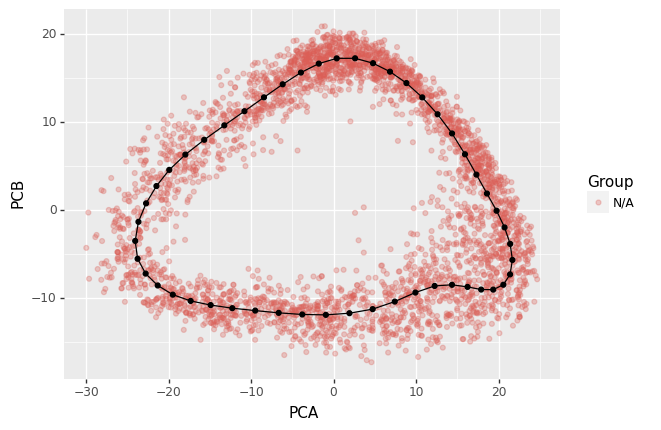

[<ggplot: (8767881758189)>]
Selected edge to remove 7
Trajectory: [[15, 8, 37, 41, 29, 23, 5, 30, 44, 20, 26, 3, 39, 45, 33, 22, 17, 0, 12, 14, 9, 40, 47, 32, 36, 24, 27, 4, 42, 1, 48, 34, 19, 16, 7, 6, 28, 46, 21, 38, 25, 43, 35, 49, 31, 10, 18, 2, 13, 11], [15]]


Iteration 1 ==================
Jaccard coeff: 0.9924242424242424 Old: 528 New: 524 

Cell cycle genes fround from the self-consistent trajectory: 524
Top ones: ['HIST1H4C', 'TOP2A', 'HMGB2', 'KPNA2', 'ASPM', 'CCNB1', 'TPX2', 'CDC20', 'HIST1H1B', 'UBE2C', 'CKS2', 'CENPE', 'NUSAP1', 'ARL6IP1', 'RRM2', 'HIST1H1D', 'DLGAP5', 'HMMR', 'CDK1', 'KIF2C', 'AURKA', 'SGO2', 'GTSE1', 'NUF2', 'KIF14', 'NCAPG', 'AURKB', 'CCNA2', 'TACC3', 'PIF1', 'NDC80', 'CDCA8']


In [123]:
# Derive self-consistent cell cycle trajectory
# This greatly reduces the effect of finding or not finding the correct ICs
# We construct the trajectory in the space of cell cycle genes which are defined from this trajectory (self-consistency)

number_of_pc_components = 30
max_number_of_iterations = 10
eps_jaccard = 0.01

ind_old = ind

for counter in range(max_number_of_iterations):
    Xcc = adata.X[:,ind]
    pca = PCA(n_components=number_of_pc_components)
    Xcc_reduced = pca.fit_transform(Xcc)
    print(Xcc_reduced.shape,type(Xcc_reduced))
    egr_sc, pst_sc, points_sc, partition_sc, traj_sc = compute_trajectory(Xcc_reduced.astype(np.float64),total_counts,
                                                     mu=mu,number_of_nodes=number_of_nodes)
    X_ro_sc, residue_matrix_sc, r2scores_sc = subtract_cell_cycle_trajectory(adata.X,partition_sc,points_sc)
    ind = np.where(r2scores_sc>r2_threshold)[0]
    idx_common_genes = list(set(ind)&set(ind_old))
    union_genes = list(set(ind)|set(ind_old))
    perc = len(idx_common_genes)/len(union_genes)
    print('\n\nIteration',counter+1,'==================\nJaccard coeff:',perc,'Old:',len(ind_old),'New:',len(ind),'\n==================\n')
    if perc>1-eps_jaccard:
        break
    ind_old = ind.copy()

print('Cell cycle genes fround from the self-consistent trajectory:',len(ind))
print('Top ones:',list(adata.var_names[np.where(r2scores>0.9)[0]]))

# From here you can go back to "Cluster cell cycle genes" cell

(150, 4)


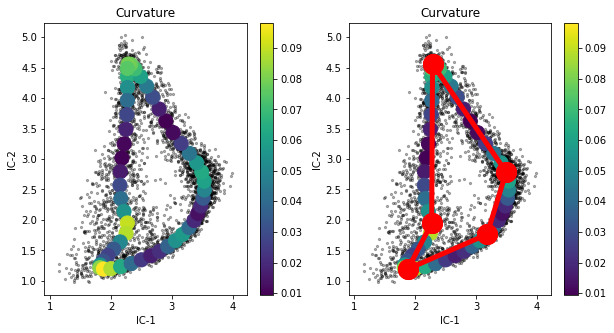

In [151]:
# Piece-wise linear approximation of the trajectory based on curvature analysis
# Projection from ICs of IC-based trajectory

traj = traj_ic
nodep = egr_ic[0]['NodePositions']
egr = egr_ic

ax1 = 0
ax2 = 1

curv = np.zeros(len(traj))
reduced_dimension = np.min([nodep.shape[1],max_dimension])
x, curv = calc_curvature_cyclic(nodep[traj,0:reduced_dimension],smoothing_factor=15)
curvature_peaks = np.array(find_peaks(curv))[0]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(cell_cycle_ics_data[:,ax1],cell_cycle_ics_data[:,ax2],c='k',alpha=0.3,s=5)
plt.scatter(nodep[traj,ax1],nodep[traj,ax2],c=curv,s=200)
plt.axis('equal')
plt.colorbar()
plt.xlabel('IC-'+str(ax1+1))
plt.ylabel('IC-'+str(ax2+1))
plt.title('Curvature')

plt.subplot(122)
plt.scatter(cell_cycle_ics_data[:,ax1],cell_cycle_ics_data[:,ax2],c='k',alpha=0.3,s=5)
plt.scatter(nodep[traj,ax1],nodep[traj,ax2],c=curv,s=200)
plt.axis('equal')
plt.colorbar()
plt.xlabel('IC-'+str(ax1+1))
plt.ylabel('IC-'+str(ax2+1))
plt.title('Curvature')

curvature_peaks_traj = np.array([traj[int(k)] for k in curvature_peaks])
for i in range(curvature_peaks_traj.shape[0]-1):
    j = int(curvature_peaks_traj[i])
    j1 = int(curvature_peaks_traj[i+1])
    xj1 = nodep[j,ax1]
    xj2 = nodep[j1,ax1]
    yj1 = nodep[j,ax2]
    yj2 = nodep[j1,ax2]
    plt.plot([xj1,xj2],[yj1,yj2],'ro-',markersize=20,linewidth=5)
j = int(curvature_peaks_traj[0])
j1 = int(curvature_peaks_traj[-1])
plt.plot([nodep[j,ax1],nodep[j1,ax1]],[nodep[j,ax2],nodep[j1,ax2]],'ro-',markersize=20,linewidth=5)
plt.show()


(150, 10)
[12 18 25 33 47]
[39 12 24 16  2]


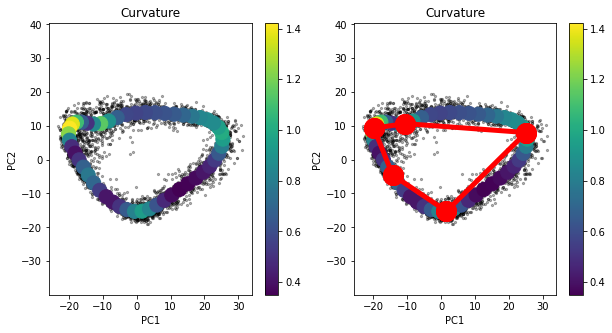

In [143]:
# Piece-wise linear approximation of the trajectory based on curvature analysis
# Projection from PCs of self-consistent trajectory

traj = traj_sc
nodep = egr_sc[0]['NodePositions']
egr = egr_sc

curv = np.zeros(len(traj))
reduced_dimension = np.min([nodep.shape[1],max_dimension])
x, curv = calc_curvature_cyclic(nodep[traj,0:reduced_dimension],smoothing_factor=15)
curvature_peaks = np.array(find_peaks(curv))[0]

ax1 = 0
ax2 = 1

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(Xcc_reduced[:,ax1],Xcc_reduced[:,ax2],c='k',alpha=0.3,s=5)
plt.scatter(nodep[traj,ax1],nodep[traj,ax2],c=curv,s=200)
plt.axis('equal')
plt.colorbar()
plt.xlabel('PC'+str(ax1+1))
plt.ylabel('PC'+str(ax2+1))
plt.title('Curvature')

plt.subplot(122)
plt.scatter(Xcc_reduced[:,ax1],Xcc_reduced[:,ax2],c='k',alpha=0.3,s=5)
plt.scatter(nodep[traj,ax1],nodep[traj,ax2],c=curv,s=200)
plt.axis('equal')
plt.colorbar()
plt.xlabel('PC'+str(ax1+1))
plt.ylabel('PC'+str(ax2+1))
plt.title('Curvature')


if True:
    curvature_peaks_traj = np.array([traj[int(k)] for k in curvature_peaks])
    print(curvature_peaks)
    print(curvature_peaks_traj)
    for i in range(curvature_peaks_traj.shape[0]-1):
        j = int(curvature_peaks_traj[i])
        j1 = int(curvature_peaks_traj[i+1])
        xj1 = nodep[j,ax1]
        xj2 = nodep[j1,ax1]
        yj1 = nodep[j,ax2]
        yj2 = nodep[j1,ax2]
        plt.plot([xj1,xj2],[yj1,yj2],'ro-',markersize=20,linewidth=5)
    j = int(curvature_peaks_traj[0])
    j1 = int(curvature_peaks_traj[-1])
    plt.plot([nodep[j,ax1],nodep[j1,ax1]],[nodep[j,ax2],nodep[j1,ax2]],'ro-',markersize=20,linewidth=5)
    plt.show()